# Cargamos datos

In [1]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
import random
import pandas as pd
import numpy as np
plt.rcParams.update({'font.size': 20})
from fastai.metrics import error_rate, accuracy




In [16]:
dic = {
      'ATYPICAL_LYMPHOCYTE':[],
      'VARIANT_LYMPHOCYTE':[],
      'BLAST':[]
     }

In [17]:
import os

def print_dirs_recursively(root_dir):
    root_dir = os.path.abspath(root_dir)

    for item in os.listdir(root_dir):
        item_full_path = os.path.join(root_dir, item)
        if os.path.isdir(item_full_path):
            print_dirs_recursively(item_full_path)
        else: 
            if '/ATYPICAL_LYMPHOCYTE/' in item_full_path:
                dic['ATYPICAL_LYMPHOCYTE'].append(item_full_path)
            if '/VARIANT_LYMPHOCYTE/' in item_full_path:
                dic['VARIANT_LYMPHOCYTE'].append(item_full_path)
            if '/BLAST/' in item_full_path:
                dic['BLAST'].append(item_full_path)

print_dirs_recursively('/shared/Clinic')

In [18]:
random.seed(4)
for item in dic.values():
     random.shuffle(item)

In [19]:
def catcher(x): return re.findall('/([a-zA-Z]+)_+[\d]', x)[0]

typ = {
      'ATYPICAL_LYMPHOCYTE':{},
      'VARIANT_LYMPHOCYTE':{},
      'BLAST':{}
     }
for name in dic.keys():
    for path in dic[name]:
        if '.jpg' in path:
            label = catcher(path)
            if label in typ[name]:
                typ[name][label] += 1

            else: 

                typ[name][label] = 1


typ

{'ATYPICAL_LYMPHOCYTE': {'LY': 664,
  'OTH': 2659,
  'VLY': 87,
  'HC': 58,
  'MO': 22,
  'BL': 7,
  'BA': 1,
  'SMU': 1},
 'VARIANT_LYMPHOCYTE': {'LY': 41, 'VLY': 486, 'MO': 24},
 'BLAST': {'BL': 1204, 'LY': 35, 'MO': 1}}

In [20]:
pd.DataFrame.from_dict(typ).replace(np.nan, "")


,ATYPICAL_LYMPHOCYTE,VARIANT_LYMPHOCYTE,BLAST
BA,1,,
BL,7,,1204
HC,58,,
LY,664,41,35
MO,22,24,1
OTH,2659,,
SMU,1,,
VLY,87,486,


In [21]:
folder_1 = os.listdir("/shared/Datasets_Classification/Classification_Clinic_Balanced/train/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/Classification_Clinic_Balanced/train/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/Classification_Clinic_Balanced/train/BLAST")

In [22]:
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':folder_1,
      'VARIANT_LYMPHOCYTE':folder_2,
      'BLAST':folder_3
     }

def catcher2(x): return re.findall('([a-zA-Z]+)_+[\d]', x)[0]

typ_2 = {
      'ATYPICAL_LYMPHOCYTE':{},
      'VARIANT_LYMPHOCYTE':{},
      'BLAST':{}
     }
for name in dic_Classif.keys():
    for path in dic_Classif[name]:
        if '.jpg' in path:
            label = catcher2(path)
            if label in typ_2[name]:
                typ_2[name][label] += 1

            else: 

                typ_2[name][label] = 1



In [23]:
df_classes = pd.DataFrame.from_dict(typ_2)

In [24]:
df_classes.replace(np.nan, "")

,ATYPICAL_LYMPHOCYTE,VARIANT_LYMPHOCYTE,BLAST
BL,1,,974
HC,22,,
LY,230,37,25
MO,9,17,1
OTH,902,,
VLY,36,395,


In [28]:
folder_classes = "/shared/Datasets_Classification/Classification_Clinic_Balanced"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)

In [29]:
data = (ImageList.from_folder(folder_classes) # Directorio de las carpetas train y test
        .split_by_rand_pct(seed=4)            # Separamos los sets de train y validation en un ratio (80/20%) 
        .label_from_folder()                  # Nombramos las clases mediante el nombre de las carpetas
        .transform(tfms, size=224)            # Data augmentation especificado en la variable tmfs 
        .databunch()
        .normalize(imagenet_stats))   

In [30]:
pd.DataFrame.from_dict({'Número de Clases':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},                     
orient = 'index', columns=['Conteo del Conjunto de Datos'])

,Conteo del Conjunto de Datos
Número de Clases,3
train_size,2331
valid_size,582


In [34]:
train_ds = data.train_ds.to_df()
train_df = pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'Conteo en el conjunto de datos Train'})
train_df

,Conteo en el conjunto de datos Train
ATYPICAL_LYMPHOCYTE,1026
BLAST,866
VARIANT_LYMPHOCYTE,439


In [35]:
valid_ds = data.valid_ds.to_df()
valid_df = pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'Conteo en el conjunto de datos Validation'})
valid_df

,Conteo en el conjunto de datos Validation
ATYPICAL_LYMPHOCYTE,243
BLAST,227
VARIANT_LYMPHOCYTE,112


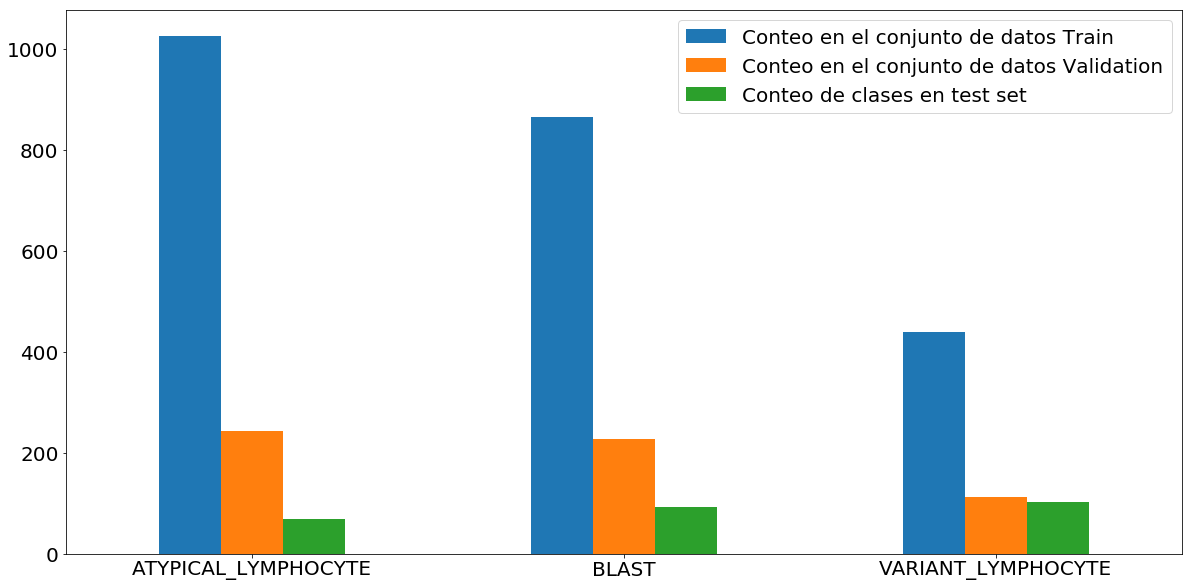

In [61]:
train_df['Conteo en el conjunto de datos Validation'] = valid_df['Conteo en el conjunto de datos Validation']
train_df['Conteo de clases en test set'] = df_test['Conteo de clases en test set']
train_df.plot.bar(rot='0',figsize=(20,10));


### Descripcion del conjunto de datos

In [18]:
gc.collect()

7

In [21]:
data.batch_size = 14

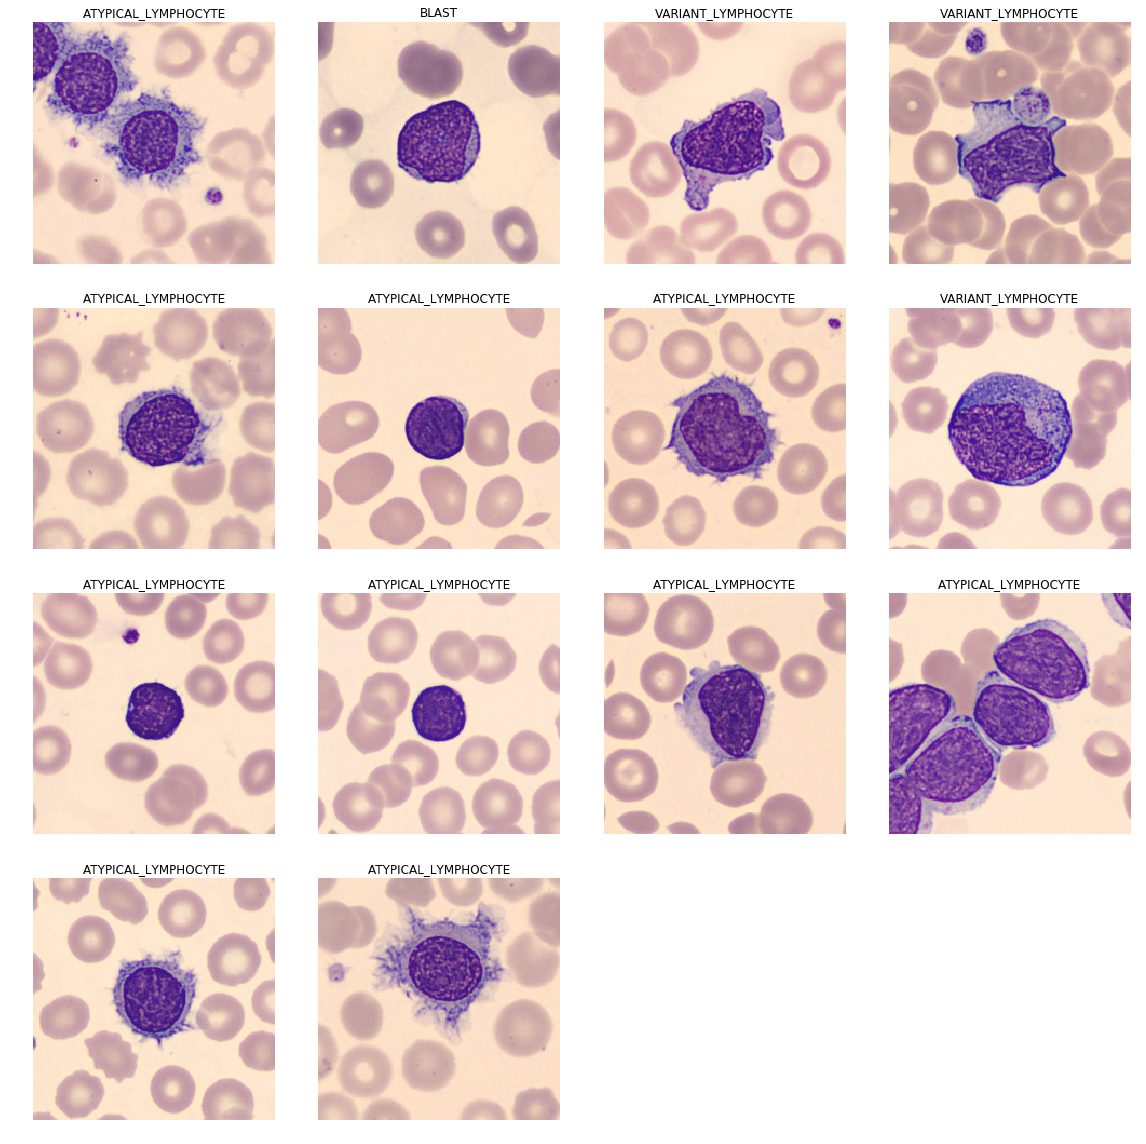

In [22]:
data.show_batch()

# Fine Tuning en Clinic de ResNet 18 

In [70]:
learn = None

In [71]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy], pretrained='imagenet')


In [72]:
learn.data.batch_size = 20

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


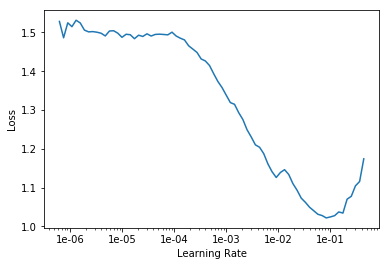

In [60]:
learn.lr_find()
learn.recorder.plot()

In [73]:
gc.collect()

4878

In [74]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.551613,0.241443,0.109966,0.890034,00:10
1,0.396501,0.197874,0.079038,0.920962,00:11
2,0.258137,0.137352,0.049828,0.950172,00:10
3,0.206484,0.122323,0.051546,0.948454,00:10
4,0.189221,0.120455,0.041237,0.958763,00:11


In [75]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.206964,0.117081,0.037801,0.962199,00:10
1,0.236988,0.124070,0.044674,0.955326,00:11
2,0.199924,0.089992,0.027491,0.972509,00:10
3,0.174945,0.095598,0.030928,0.969072,00:10


In [76]:
learn.export('export_stage-1-18-Clinic_Balanced_3_Classes')

In [77]:
learn.unfreeze()
learn.fit_one_cycle((5), max_lr=slice(3e-4,3e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.363322,0.365199,0.092784,0.907216,00:11
1,0.469639,1.419887,0.250859,0.749141,00:11
2,0.325330,0.103184,0.037801,0.962199,00:11
3,0.213607,0.085662,0.022337,0.977663,00:11
4,0.116765,0.068961,0.017182,0.982818,00:11


In [78]:
learn.fit_one_cycle((5), max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.110433,0.112140,0.032646,0.967354,00:12
1,0.129214,0.096011,0.032646,0.967354,00:11
2,0.102649,0.061736,0.013746,0.986254,00:12
3,0.085990,0.090069,0.027491,0.972509,00:12
4,0.073994,0.061438,0.015464,0.984536,00:12


In [79]:
learn.fit_one_cycle((3), max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.086522,0.058021,0.013746,0.986254,00:09
1,0.082171,0.062789,0.017182,0.982818,00:09
2,0.095025,0.061189,0.015464,0.984536,00:09


In [80]:
learn.fit_one_cycle((3), max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.106940,0.056918,0.013746,0.986254,00:09
1,0.076529,0.075450,0.018900,0.981100,00:09
2,0.065354,0.058289,0.012027,0.987972,00:09


In [81]:
learn.fit_one_cycle((2), max_lr=slice(3e-7))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.074843,0.060242,0.013746,0.986254,00:09
1,0.079134,0.060347,0.013746,0.986254,00:09


In [82]:
learn.fit_one_cycle((2), max_lr=slice(3e-7))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.076004,0.062473,0.015464,0.984536,00:09
1,0.064889,0.069597,0.022337,0.977663,00:09


In [83]:
learn.fit_one_cycle((2), max_lr=slice(3e-7, 3e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.076433,0.065307,0.020619,0.979381,00:09
1,0.080250,0.066107,0.018900,0.981100,00:09


In [84]:
learn.export('export_stage-2-18-Clinic_Balanced_3_Classes')

In [85]:
interp = ClassificationInterpretation.from_learner(learn)

interp.most_confused(min_val=2)

[('BLAST', 'VARIANT_LYMPHOCYTE', 4),
 ('ATYPICAL_LYMPHOCYTE', 'VARIANT_LYMPHOCYTE', 3),
 ('ATYPICAL_LYMPHOCYTE', 'BLAST', 2)]

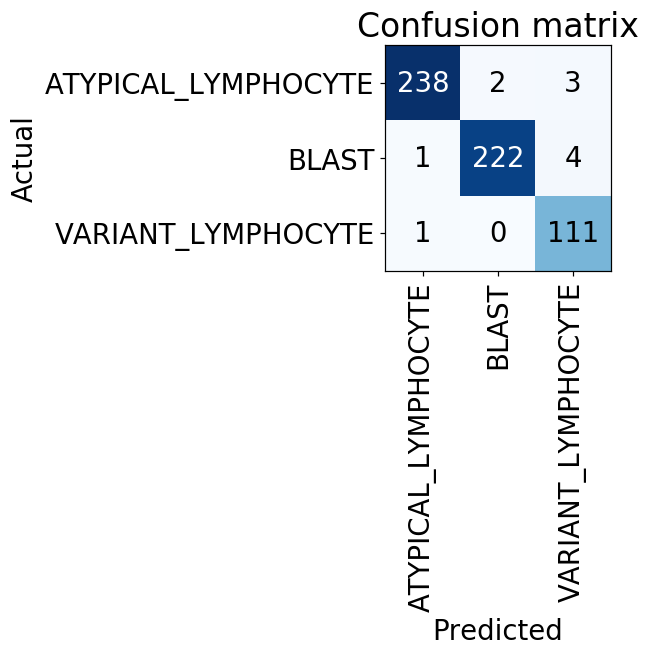

In [90]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110)

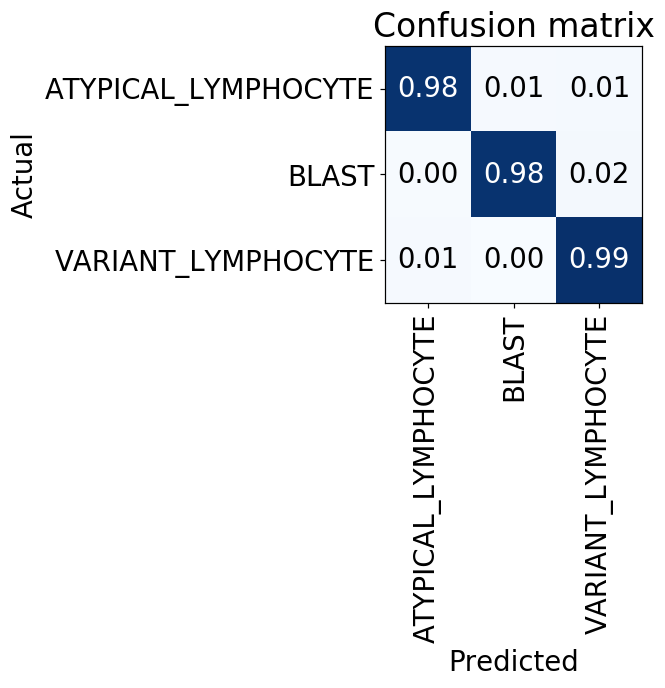

In [91]:
interp.plot_confusion_matrix(figsize=(6,8), dpi=110,normalize = True)

Validando el ``test_set``






In [45]:
data_test = (ImageList.from_folder(folder_classes)    # Directorio de las carpetas train y test
        .split_by_folder(train='train', valid='test') # Se selecciona la carpeta de test para validar
        .label_from_folder()                          # Etiquetación de la imagen según carpeta
        .transform(tfms, size=224)        
        .databunch()
        .normalize(imagenet_stats))   

metrics_valid = learn_test.validate(data_test.valid_dl)

In [46]:
data_test

ImageDataBunch;

Train: LabelList (2649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
BLAST,BLAST,BLAST,BLAST,BLAST
Path: /shared/Datasets_Classification/Classification_Clinic_Balanced;

Valid: LabelList (264 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
BLAST,BLAST,BLAST,BLAST,BLAST
Path: /shared/Datasets_Classification/Classification_Clinic_Balanced;

Test: None

In [50]:
valid_ds = data_test.valid_ds.to_df()
df_test=pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'Conteo de clases en test set'})
df_test

,Conteo de clases en test set
VARIANT_LYMPHOCYTE,102
BLAST,93
ATYPICAL_LYMPHOCYTE,69


In [95]:
learn_test = load_learner( '/shared/Classification_Clinic_Balanced', 'export_stage-2-18-Clinic_Balanced_3_Classes') 
learn_test.data = data_test
learn_test.data.batch_size = 20

In [96]:
metrics_valid = learn_test.validate(data_test.valid_dl)

In [97]:
valid_results = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [metrics_valid[0], metrics_valid[1].item(),metrics_valid[2].item()]))
pd.DataFrame(valid_results, index = ['metrics'])

,valid_loss,error_rate,accuracy
metrics,0.043269,0.018939,0.981061


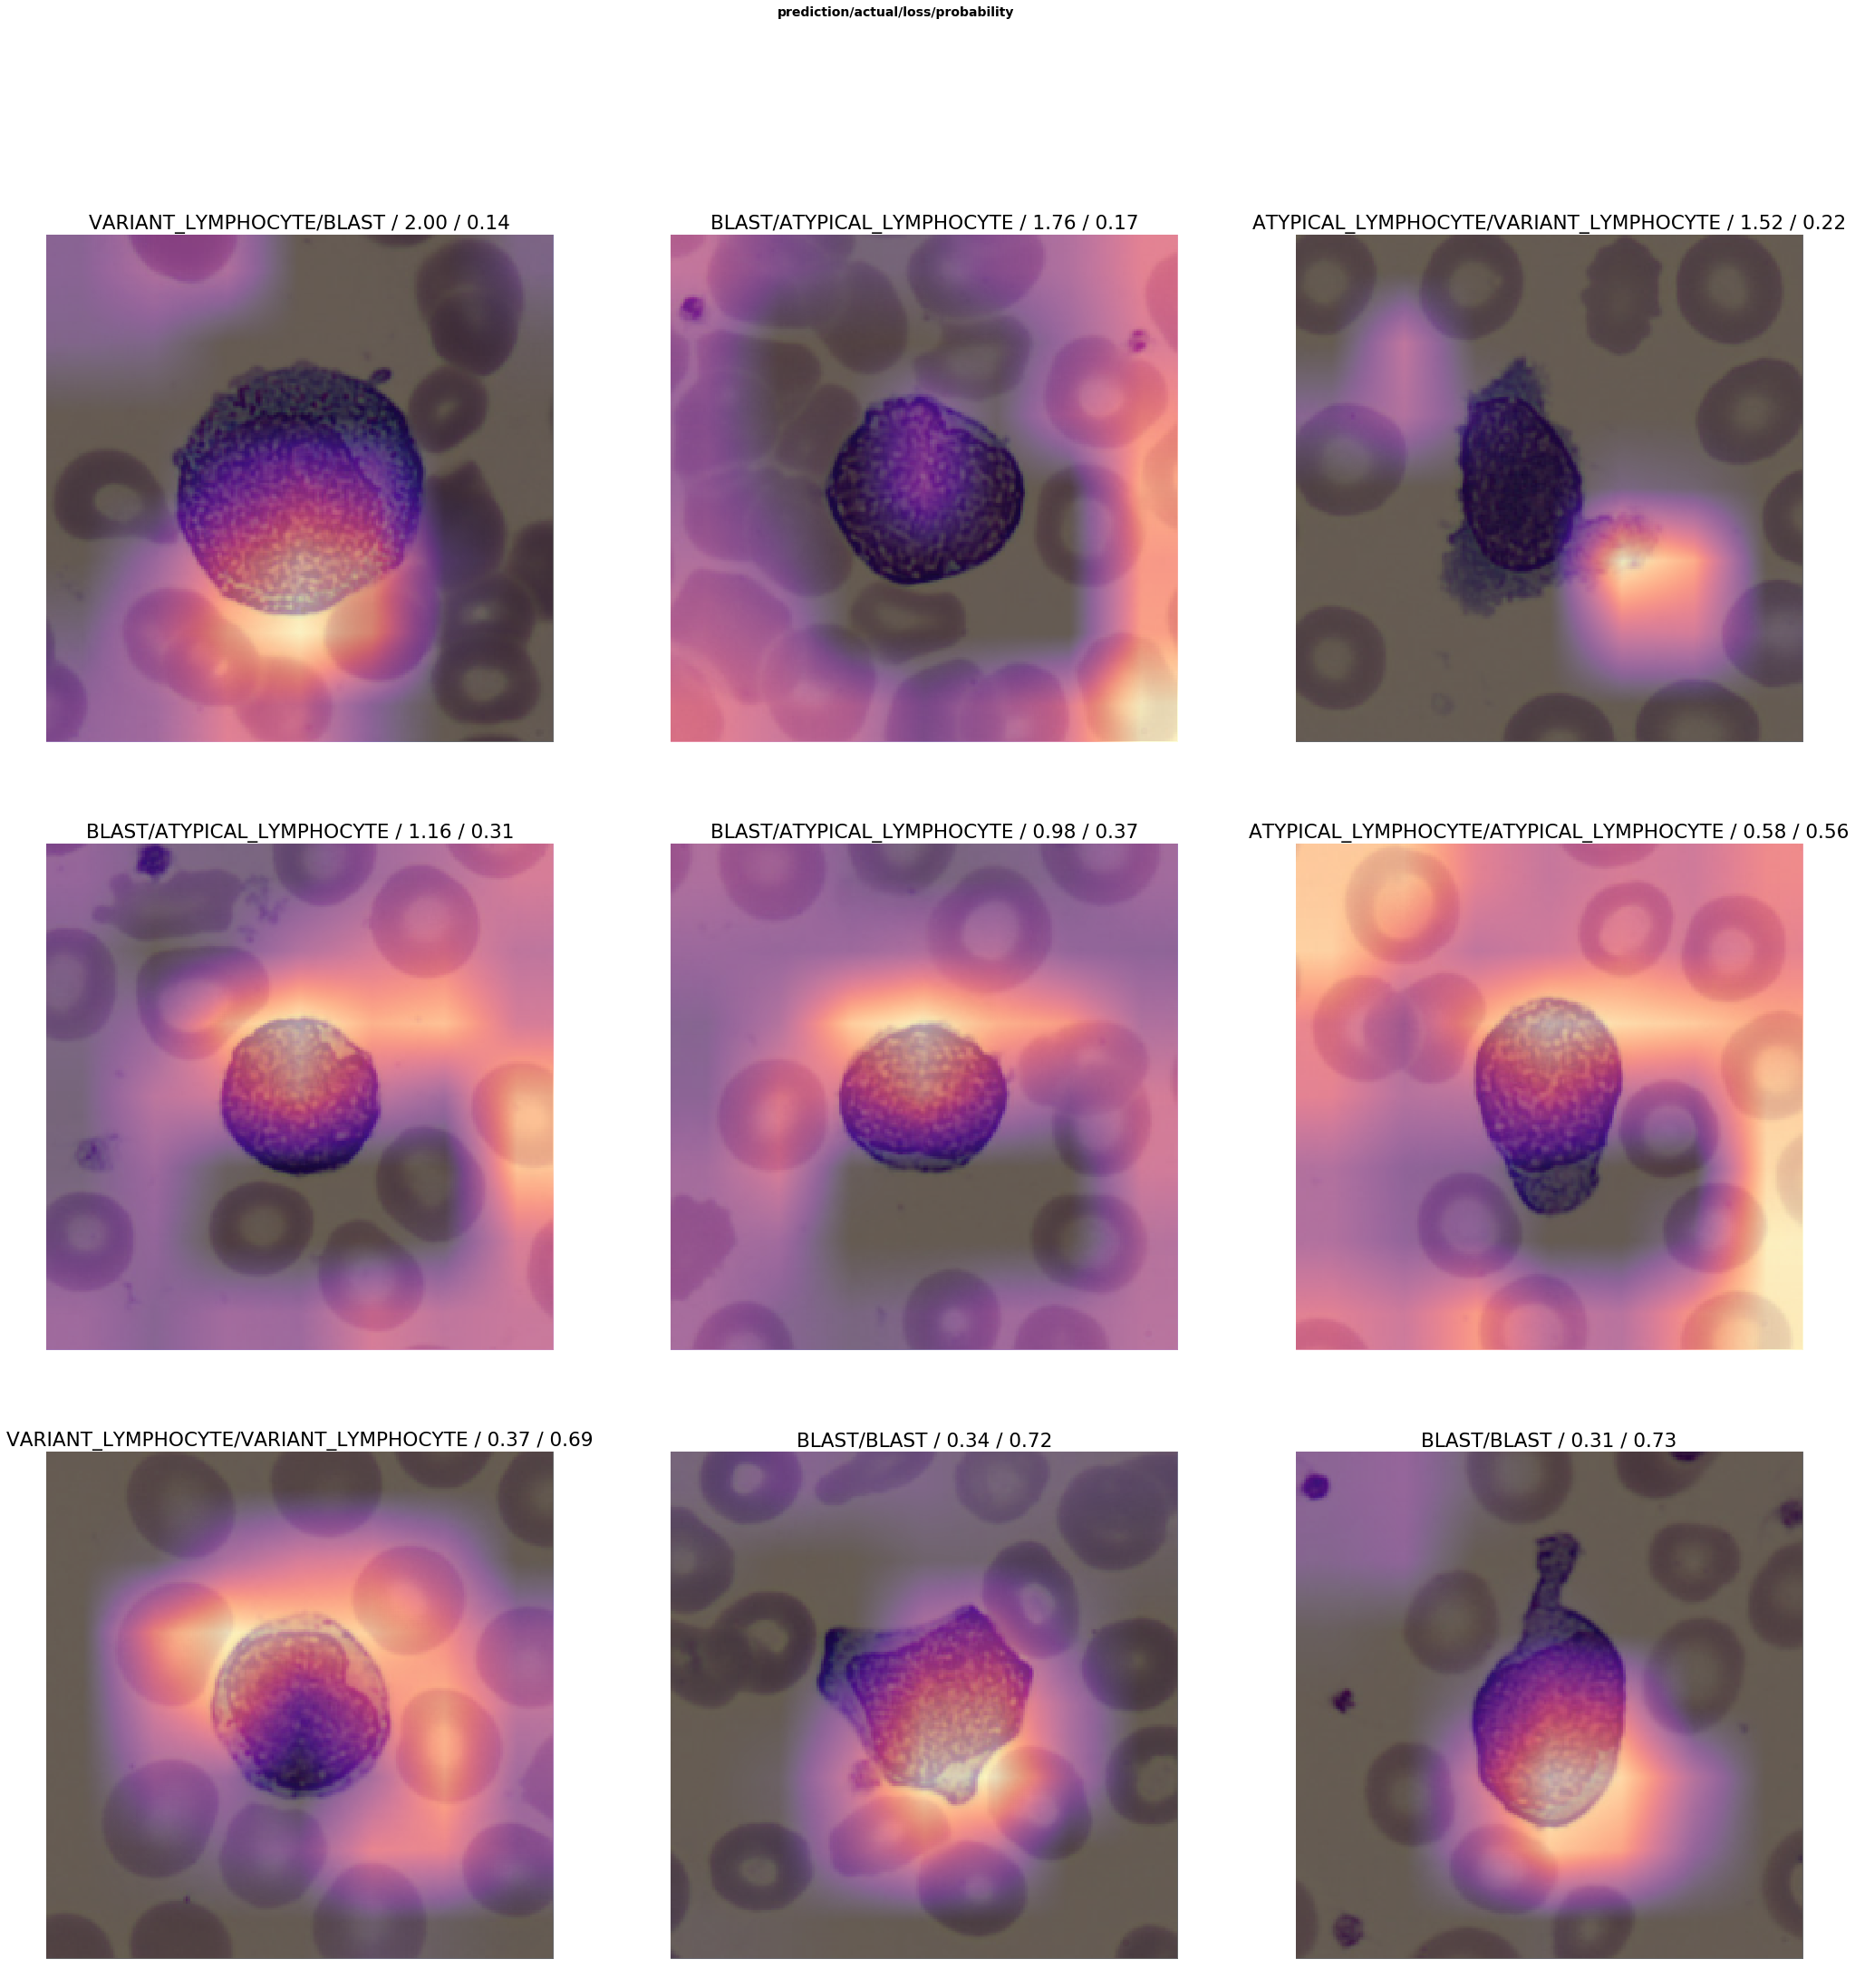

In [98]:
interp = ClassificationInterpretation.from_learner(learn_test)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, largest=True, figsize=(35,35), heatmap=True)

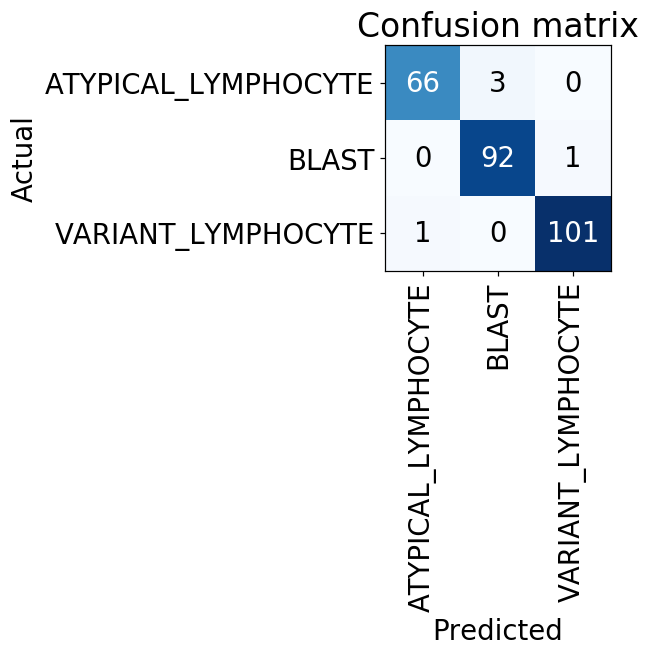

In [99]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=110)



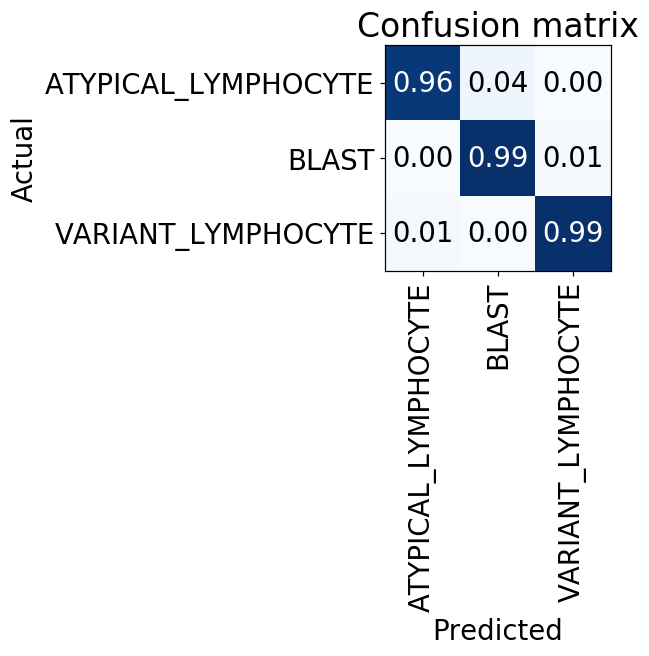

In [100]:
interp = ClassificationInterpretation.from_learner(learn_test)
interp.plot_confusion_matrix(figsize=(6,6), dpi=110, normalize=True)



In [101]:
len(data_test.valid_ds)==len(losses)==len(idxs)

True